In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
import funcs as func
import sys

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit,ShuffleSplit
import sklearn.metrics as skl_met
import pdb
from statsmodels.discrete.discrete_model import MNLogit # from_formula
import matplotlib.pyplot as plt
import os

cwd = os.getcwd()

print(cwd)
data_dir = cwd+"/Data/Y_maze/data_with_animal_ids/"
data_target_dir = cwd+"/Data/processed_data/Y_maze/data_with_animal_ids/"
figure_dir = cwd+"/Figures/"


plt.rcParams["figure.facecolor"] = "w"

/home/jyotika/2-arm-bandit-task


In [2]:


all_conflicts = pd.read_csv(data_target_dir+"all_experiments_df_with_DTs.csv")
all_conflicts["block_code"] = [ 1 if x=="left" else 0 for x in  all_conflicts["block"]]
all_conflicts = all_conflicts.rename(columns={"RT(ms)":"RT"})

In [3]:
all_conflicts

,Unnamed: 0,level_0,index,conflict,condition,volatility,event_marker,block,reward_probability,trial_length_range,...,chosen_action,rewarded,animal_id,optimal_action,revised_session_id_x,RT,revised_session_id_y,rewarded_code,conflict + volatility,block_code
0,0,0,0,Low,iSPN-Control,High,1.0,left,10-90,10-20,...,left,rewarded,1,1.0,0,596,0,1,Low - High,1
1,1,1,1,Low,iSPN-Control,High,1.0,left,10-90,10-20,...,left,rewarded,1,1.0,0,1072,0,1,Low - High,1
2,2,2,2,Low,iSPN-Control,High,1.0,left,10-90,10-20,...,left,rewarded,1,1.0,0,1056,0,1,Low - High,1
3,3,3,3,Low,iSPN-Control,High,1.0,left,10-90,10-20,...,left,rewarded,1,1.0,0,714,0,1,Low - High,1
4,4,4,4,Low,iSPN-Control,High,8.0,left,10-90,10-20,...,right,unrewarded,1,0.0,0,351,0,0,Low - High,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277730,277730,5787,10328,High,dSPN-Control,High,8.0,left,25-75,10-20,...,right,unrewarded,10,0.0,4,391,4,0,High - High,1
277731,277731,5788,10329,High,dSPN-Control,High,1.0,left,25-75,10-20,...,left,rewarded,10,1.0,4,308,4,1,High - High,1
277732,277732,5789,10330,High,dSPN-Control,High,1.0,left,25-75,10-20,...,left,rewarded,10,1.0,4,222,4,1,High - High,1
277733,277733,5790,10331,High,dSPN-Control,High,1.0,left,25-75,10-20,...,left,rewarded,10,1.0,4,448,4,1,High - High,1


In [38]:
all_conflicts.columns

Index(['Unnamed: 0', 'level_0', 'index', 'conflict', 'condition', 'volatility',
       'event_marker', 'block', 'reward_probability', 'trial_length_range',
       'session', 'block_num', 'trial_num', 'chosen_action', 'rewarded',
       'animal_id', 'optimal_action', 'revised_session_id_x', 'RT',
       'revised_session_id_y', 'rewarded_code', 'conflict + volatility',
       'block_code'],
      dtype='object')

In [29]:
test_ratio = 0.25
seed =np.random.randint(0,999999999) 
nsplits = 20

accuracy = pd.DataFrame(columns=["dependent_var","group","accuracy_score","trial_no","coefficients(animal)","animal_id"])
accuracy_shuff = pd.DataFrame(columns=["dependent_var","group","accuracy_score","trial_no","coefficients(animal)","animal_id"])



for grp in all_conflicts.groupby(["conflict","volatility"]):
    
    dat_slice = grp[1].copy()
    Y = dat_slice[["optimal_action"]]
    X = dat_slice[["block_code","RT","animal_id","condition"]]
    # optimal_action ~ block_code + rt + animal_id

    skf = ShuffleSplit(n_splits=nsplits, test_size=test_ratio, train_size = 1-test_ratio)
    
    for i,(train_index,test_index) in enumerate(skf.split(X,Y)):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        
        Y_train = Y.iloc[train_index]
        Y_test = Y.iloc[test_index]
        
        df_train = pd.concat((X_train,Y_train),axis=1)
        df_train = df_train.reset_index()
        df_test = pd.concat((X_test,Y_test),axis=1)
        
        
        formula = "optimal_action ~ RT"
        md_pre = sm.MixedLM.from_formula(formula, df_train,groups=df_train["condition"])
        mdf_pre = md_pre.fit()
        
        
        print(mdf_pre.summary())
        print(mdf_pre.random_effects)
        
        predict = np.array(mdf_pre.predict(X_test))
        predict[predict<=0.5]=0.0
        predict[predict>0.5]=1.0
        score = skl_met.accuracy_score(predict,Y_test.values)
        
        temp = pd.DataFrame()
#         temp["animal_id"] = list(pd.DataFrame(mdf_pre.random_effects).columns)
        temp["condition"] = list(pd.DataFrame(mdf_pre.random_effects).columns)
        temp["coefficients(animal)"] = pd.DataFrame(mdf_pre.random_effects).values[0]
        temp["dependent_var"] = "optimal_action"
        temp["group"] = "condition"
        temp["accuracy_score"] = score
        temp["trial_no"] = i
        temp["conflict"] = grp[0][0]
        temp["volatility"] = grp[0][1]
        
        for par in mdf_pre.params.keys():
            if "Group" in par:
                continue
            temp[par+"(group)"] = mdf_pre.params[par]
        
        accuracy = accuracy.append(temp)
        
        
        
        


/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2423        
Min. group size:  1866    Log-Likelihood:     -21545.8199   
Max. group size:  12482   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.581     0.029  20.135  0.000   0.524   0.638
RT            -0.000     0.000  -1.161  0.246  -0.000   0.000
Group Var      0.003     0.006                               

{'dSPN-Control': Group    0.039618
dtype: float64, 'dSPN-Stim': Group    0.05139
dtype: float64, 'iSPN-Control': Group   -0.019481
dtype: float64, 'iSPN-Stim': Group   -0.071527
dtype: float64}
           Mixed L

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2422        
Min. group size:  1881    Log-Likelihood:     -21541.5519   
Max. group size:  12536   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.582     0.028  20.876  0.000   0.528   0.637
RT            -0.000     0.000  -0.624  0.532  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.038277
dtype: float64, 'dSPN-Stim': Group    0.050162
dtype: float64, 'iSPN-Control': Group   -0.02075
dtype: float64, 'iSPN-Stim': Group   -0.067689
dtype: float64}
           Mixed L

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2424        
Min. group size:  1864    Log-Likelihood:     -21558.1456   
Max. group size:  12464   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.583     0.029  20.295  0.000   0.527   0.640
RT            -0.000     0.000  -0.560  0.575  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.033319
dtype: float64, 'dSPN-Stim': Group    0.058283
dtype: float64, 'iSPN-Control': Group   -0.024226
dtype: float64, 'iSPN-Stim': Group   -0.067376
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2425        
Min. group size:  1836    Log-Likelihood:     -21558.8146   
Max. group size:  12448   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.583     0.029  20.209  0.000   0.527   0.640
RT            -0.000     0.000  -1.315  0.188  -0.000   0.000
Group Var      0.003     0.006                               

{'dSPN-Control': Group    0.033474
dtype: float64, 'dSPN-Stim': Group    0.057685
dtype: float64, 'iSPN-Control': Group   -0.022113
dtype: float64, 'iSPN-Stim': Group   -0.069046
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2418        
Min. group size:  1871    Log-Likelihood:     -21517.0085   
Max. group size:  12442   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.588     0.028  21.269  0.000   0.534   0.642
RT            -0.000     0.000  -1.471  0.141  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.032472
dtype: float64, 'dSPN-Stim': Group    0.054974
dtype: float64, 'iSPN-Control': Group   -0.022171
dtype: float64, 'iSPN-Stim': Group   -0.065275
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2423        
Min. group size:  1864    Log-Likelihood:     -21546.1407   
Max. group size:  12439   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.585     0.027  21.421  0.000   0.531   0.638
RT            -0.000     0.000  -0.669  0.504  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.032178
dtype: float64, 'dSPN-Stim': Group    0.054112
dtype: float64, 'iSPN-Control': Group   -0.021915
dtype: float64, 'iSPN-Stim': Group   -0.064375
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2420        
Min. group size:  1875    Log-Likelihood:     -21528.6148   
Max. group size:  12421   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.585     0.028  21.232  0.000   0.531   0.639
RT            -0.000     0.000  -1.779  0.075  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.036917
dtype: float64, 'dSPN-Stim': Group    0.050934
dtype: float64, 'iSPN-Control': Group   -0.022013
dtype: float64, 'iSPN-Stim': Group   -0.065837
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2424        
Min. group size:  1832    Log-Likelihood:     -21557.4266   
Max. group size:  12406   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.586     0.031  18.991  0.000   0.525   0.646
RT            -0.000     0.000  -0.852  0.394  -0.000   0.000
Group Var      0.004     0.006                               

{'dSPN-Control': Group    0.028818
dtype: float64, 'dSPN-Stim': Group    0.067977
dtype: float64, 'iSPN-Control': Group   -0.026507
dtype: float64, 'iSPN-Stim': Group   -0.070289
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2422        
Min. group size:  1834    Log-Likelihood:     -21539.3277   
Max. group size:  12445   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.587     0.028  20.777  0.000   0.531   0.642
RT            -0.000     0.000  -1.374  0.169  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.033247
dtype: float64, 'dSPN-Stim': Group    0.057309
dtype: float64, 'iSPN-Control': Group   -0.026178
dtype: float64, 'iSPN-Stim': Group   -0.064378
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30311   Method:             REML          
No. Groups:       4       Scale:              0.2418        
Min. group size:  1834    Log-Likelihood:     -21516.3142   
Max. group size:  12525   Converged:          Yes           
Mean group size:  7577.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.585     0.028  20.647  0.000   0.530   0.641
RT            -0.000     0.000  -1.061  0.289  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.038378
dtype: float64, 'dSPN-Stim': Group    0.051508
dtype: float64, 'iSPN-Control': Group   -0.021196
dtype: float64, 'iSPN-Stim': Group   -0.06869
dtype: float64}
           Mixed L

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2416        
Min. group size:  6257    Log-Likelihood:     -28662.9111   
Max. group size:  14991   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.581     0.029  20.333  0.000   0.525   0.637
RT            -0.000     0.000  -2.406  0.016  -0.000  -0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.051812
dtype: float64, 'dSPN-Stim': Group    0.034624
dtype: float64, 'iSPN-Control': Group   -0.011806
dtype: float64, 'iSPN-Stim': Group   -0.07463
dtype: float64}
           Mixed L

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2415        
Min. group size:  6267    Log-Likelihood:     -28654.1658   
Max. group size:  14930   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.582     0.027  21.325  0.000   0.529   0.636
RT            -0.000     0.000  -2.491  0.013  -0.000  -0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.050614
dtype: float64, 'dSPN-Stim': Group    0.031258
dtype: float64, 'iSPN-Control': Group   -0.010377
dtype: float64, 'iSPN-Stim': Group   -0.071495
dtype: float64}


/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2418        
Min. group size:  6257    Log-Likelihood:     -28679.4966   
Max. group size:  15066   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.578     0.029  19.813  0.000   0.521   0.636
RT            -0.000     0.000  -2.407  0.016  -0.000  -0.000
Group Var      0.003     0.006                               

{'dSPN-Control': Group    0.053102
dtype: float64, 'dSPN-Stim': Group    0.034735
dtype: float64, 'iSPN-Control': Group   -0.010409
dtype: float64, 'iSPN-Stim': Group   -0.077428
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2417        
Min. group size:  6252    Log-Likelihood:     -28666.1553   
Max. group size:  15096   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.580     0.027  21.254  0.000   0.527   0.634
RT            -0.000     0.000  -1.310  0.190  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.051485
dtype: float64, 'dSPN-Stim': Group    0.029904
dtype: float64, 'iSPN-Control': Group   -0.009847
dtype: float64, 'iSPN-Stim': Group   -0.071543
dtype: float64}


/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2416        
Min. group size:  6262    Log-Likelihood:     -28657.2592   
Max. group size:  14985   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.580     0.028  21.000  0.000   0.526   0.635
RT            -0.000     0.000  -1.009  0.313  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.049293
dtype: float64, 'dSPN-Stim': Group    0.032691
dtype: float64, 'iSPN-Control': Group   -0.008373
dtype: float64, 'iSPN-Stim': Group   -0.073611
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2411        
Min. group size:  6249    Log-Likelihood:     -28618.4103   
Max. group size:  15002   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.583     0.029  19.948  0.000   0.526   0.640
RT            -0.000     0.000  -1.692  0.091  -0.000   0.000
Group Var      0.003     0.006                               

{'dSPN-Control': Group    0.050976
dtype: float64, 'dSPN-Stim': Group    0.037632
dtype: float64, 'iSPN-Control': Group   -0.010987
dtype: float64, 'iSPN-Stim': Group   -0.077621
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2414        
Min. group size:  6219    Log-Likelihood:     -28644.4445   
Max. group size:  15020   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.582     0.028  20.702  0.000   0.527   0.637
RT            -0.000     0.000  -1.027  0.304  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.049475
dtype: float64, 'dSPN-Stim': Group    0.036785
dtype: float64, 'iSPN-Control': Group   -0.013272
dtype: float64, 'iSPN-Stim': Group   -0.072989
dtype: float64}


/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2414        
Min. group size:  6293    Log-Likelihood:     -28642.2113   
Max. group size:  14990   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.581     0.029  19.986  0.000   0.524   0.638
RT            -0.000     0.000  -3.388  0.001  -0.000  -0.000
Group Var      0.003     0.006                               

{'dSPN-Control': Group    0.052831
dtype: float64, 'dSPN-Stim': Group    0.032978
dtype: float64, 'iSPN-Control': Group   -0.007563
dtype: float64, 'iSPN-Stim': Group   -0.078247
dtype: float64}


/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2415        
Min. group size:  6276    Log-Likelihood:     -28652.5563   
Max. group size:  14994   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.582     0.028  20.630  0.000   0.526   0.637
RT            -0.000     0.000  -1.668  0.095  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.046074
dtype: float64, 'dSPN-Stim': Group    0.038648
dtype: float64, 'iSPN-Control': Group   -0.009566
dtype: float64, 'iSPN-Stim': Group   -0.075156
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2416        
Min. group size:  6233    Log-Likelihood:     -28656.5990   
Max. group size:  15094   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.582     0.027  21.328  0.000   0.528   0.635
RT            -0.000     0.000  -2.151  0.031  -0.000  -0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.047754
dtype: float64, 'dSPN-Stim': Group    0.03243
dtype: float64, 'iSPN-Control': Group   -0.00698
dtype: float64, 'iSPN-Stim': Group   -0.073205
dtype: float64}
           Mixed Li

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2414        
Min. group size:  6315    Log-Likelihood:     -28643.3537   
Max. group size:  14990   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.581     0.029  19.946  0.000   0.524   0.638
RT            -0.000     0.000  -2.032  0.042  -0.000  -0.000
Group Var      0.003     0.006                               

{'dSPN-Control': Group    0.053363
dtype: float64, 'dSPN-Stim': Group    0.034175
dtype: float64, 'iSPN-Control': Group   -0.010361
dtype: float64, 'iSPN-Stim': Group   -0.077178
dtype: float64}


/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2414        
Min. group size:  6280    Log-Likelihood:     -28642.5341   
Max. group size:  14995   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.580     0.029  20.208  0.000   0.524   0.637
RT            -0.000     0.000  -1.480  0.139  -0.000   0.000
Group Var      0.003     0.005                               

{'dSPN-Control': Group    0.050647
dtype: float64, 'dSPN-Stim': Group    0.032663
dtype: float64, 'iSPN-Control': Group   -0.005006
dtype: float64, 'iSPN-Stim': Group   -0.078304
dtype: float64}


/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 40404   Method:             REML          
No. Groups:       4       Scale:              0.2416        
Min. group size:  6202    Log-Likelihood:     -28658.0507   
Max. group size:  14949   Converged:          Yes           
Mean group size:  10101.0                                   
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.580     0.029  20.070  0.000   0.523   0.636
RT            -0.000     0.000  -2.596  0.009  -0.000  -0.000
Group Var      0.003     0.006                               

{'dSPN-Control': Group    0.050749
dtype: float64, 'dSPN-Stim': Group    0.032974
dtype: float64, 'iSPN-Control': Group   -0.004853
dtype: float64, 'iSPN-Stim': Group   -0.078871
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30819   Method:             REML          
No. Groups:       4       Scale:              0.2262        
Min. group size:  1932    Log-Likelihood:     -20852.1993   
Max. group size:  13612   Converged:          Yes           
Mean group size:  7704.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.643     0.051  12.507  0.000   0.542   0.744
RT            -0.000     0.000  -1.125  0.261  -0.000   0.000
Group Var      0.011     0.018                               

{'dSPN-Control': Group    0.074653
dtype: float64, 'dSPN-Stim': Group    0.089093
dtype: float64, 'iSPN-Control': Group   -0.03294
dtype: float64, 'iSPN-Stim': Group   -0.130806
dtype: float64}
           Mixed L

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30819   Method:             REML          
No. Groups:       4       Scale:              0.2257        
Min. group size:  1949    Log-Likelihood:     -20818.4734   
Max. group size:  13596   Converged:          Yes           
Mean group size:  7704.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.644     0.054  11.926  0.000   0.538   0.749
RT            -0.000     0.000  -1.331  0.183  -0.000   0.000
Group Var      0.012     0.020                               

{'dSPN-Control': Group    0.076086
dtype: float64, 'dSPN-Stim': Group    0.093249
dtype: float64, 'iSPN-Control': Group   -0.033353
dtype: float64, 'iSPN-Stim': Group   -0.135983
dtype: float64}
           Mixed 

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 30819   Method:             REML          
No. Groups:       4       Scale:              0.2262        
Min. group size:  1969    Log-Likelihood:     -20850.8671   
Max. group size:  13688   Converged:          Yes           
Mean group size:  7704.8                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.643     0.053  12.156  0.000   0.540   0.747
RT            -0.000     0.000  -1.179  0.238  -0.000   0.000
Group Var      0.011     0.019                               

{'dSPN-Control': Group    0.073294
dtype: float64, 'dSPN-Stim': Group    0.094071
dtype: float64, 'iSPN-Control': Group   -0.033491
dtype: float64, 'iSPN-Stim': Group   -0.133874
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2237        
Min. group size:  5528    Log-Likelihood:     -25553.3274   
Max. group size:  15290   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.044  14.880  0.000   0.563   0.734
RT            -0.000     0.000  -4.377  0.000  -0.000  -0.000
Group Var      0.008     0.013                               

{'dSPN-Control': Group    0.074459
dtype: float64, 'dSPN-Stim': Group    0.048014
dtype: float64, 'iSPN-Control': Group   -0.002471
dtype: float64, 'iSPN-Stim': Group   -0.120002
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2242        
Min. group size:  5509    Log-Likelihood:     -25594.7753   
Max. group size:  15228   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.042  15.562  0.000   0.567   0.731
RT            -0.000     0.000  -4.226  0.000  -0.000  -0.000
Group Var      0.007     0.012                               

{'dSPN-Control': Group    0.070745
dtype: float64, 'dSPN-Stim': Group    0.047473
dtype: float64, 'iSPN-Control': Group   -0.003637
dtype: float64, 'iSPN-Stim': Group   -0.114581
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2234        
Min. group size:  5531    Log-Likelihood:     -25524.3772   
Max. group size:  15270   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.651     0.044  14.736  0.000   0.564   0.737
RT            -0.000     0.000  -4.610  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.074745
dtype: float64, 'dSPN-Stim': Group    0.050647
dtype: float64, 'iSPN-Control': Group   -0.004341
dtype: float64, 'iSPN-Stim': Group   -0.121051
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2240        
Min. group size:  5545    Log-Likelihood:     -25574.3979   
Max. group size:  15245   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.042  15.386  0.000   0.566   0.732
RT            -0.000     0.000  -4.234  0.000  -0.000  -0.000
Group Var      0.007     0.012                               

{'dSPN-Control': Group    0.071585
dtype: float64, 'dSPN-Stim': Group    0.047714
dtype: float64, 'iSPN-Control': Group   -0.003301
dtype: float64, 'iSPN-Stim': Group   -0.115999
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2241        
Min. group size:  5535    Log-Likelihood:     -25579.1294   
Max. group size:  15274   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.648     0.043  15.037  0.000   0.563   0.732
RT            -0.000     0.000  -4.253  0.000  -0.000  -0.000
Group Var      0.007     0.013                               

{'dSPN-Control': Group    0.072687
dtype: float64, 'dSPN-Stim': Group    0.048727
dtype: float64, 'iSPN-Control': Group   -0.002712
dtype: float64, 'iSPN-Stim': Group   -0.118702
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2241        
Min. group size:  5460    Log-Likelihood:     -25582.9782   
Max. group size:  15191   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.648     0.044  14.862  0.000   0.562   0.733
RT            -0.000     0.000  -4.050  0.000  -0.000  -0.000
Group Var      0.008     0.013                               

{'dSPN-Control': Group    0.074947
dtype: float64, 'dSPN-Stim': Group    0.048791
dtype: float64, 'iSPN-Control': Group   -0.004482
dtype: float64, 'iSPN-Stim': Group   -0.119255
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2231        
Min. group size:  5553    Log-Likelihood:     -25499.6304   
Max. group size:  15225   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.650     0.045  14.598  0.000   0.562   0.737
RT            -0.000     0.000  -4.062  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.077963
dtype: float64, 'dSPN-Stim': Group    0.045945
dtype: float64, 'iSPN-Control': Group   -0.001432
dtype: float64, 'iSPN-Stim': Group   -0.122477
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2226        
Min. group size:  5474    Log-Likelihood:     -25456.1627   
Max. group size:  15327   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.653     0.045  14.474  0.000   0.564   0.741
RT            -0.000     0.000  -5.543  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.073909
dtype: float64, 'dSPN-Stim': Group    0.051899
dtype: float64, 'iSPN-Control': Group   -0.000728
dtype: float64, 'iSPN-Stim': Group   -0.12508
dtype: float64}
           Mixed L

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2237        
Min. group size:  5514    Log-Likelihood:     -25549.4857   
Max. group size:  15235   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.045  14.543  0.000   0.562   0.737
RT            -0.000     0.000  -4.212  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.076218
dtype: float64, 'dSPN-Stim': Group    0.052088
dtype: float64, 'iSPN-Control': Group   -0.006818
dtype: float64, 'iSPN-Stim': Group   -0.121488
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38082   Method:             REML          
No. Groups:       4       Scale:              0.2238        
Min. group size:  5532    Log-Likelihood:     -25556.5450   
Max. group size:  15155   Converged:          Yes           
Mean group size:  9520.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.044  14.810  0.000   0.563   0.735
RT            -0.000     0.000  -4.727  0.000  -0.000  -0.000
Group Var      0.008     0.013                               

{'dSPN-Control': Group    0.073342
dtype: float64, 'dSPN-Stim': Group    0.050039
dtype: float64, 'iSPN-Control': Group   -0.002537
dtype: float64, 'iSPN-Stim': Group   -0.120845
dtype: float64}
           Mixed 

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 29734   Method:             REML          
No. Groups:       4       Scale:              0.2230        
Min. group size:  2148    Log-Likelihood:     -19907.9406   
Max. group size:  12440   Converged:          Yes           
Mean group size:  7433.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.650     0.053  12.373  0.000   0.547   0.753
RT            -0.000     0.000  -0.661  0.508  -0.000   0.000
Group Var      0.011     0.019                               

{'dSPN-Control': Group    0.065588
dtype: float64, 'dSPN-Stim': Group    0.091694
dtype: float64, 'iSPN-Control': Group   -0.016586
dtype: float64, 'iSPN-Stim': Group   -0.140696
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 29734   Method:             REML          
No. Groups:       4       Scale:              0.2234        
Min. group size:  2054    Log-Likelihood:     -19931.5535   
Max. group size:  12486   Converged:          Yes           
Mean group size:  7433.5                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.652     0.050  13.039  0.000   0.554   0.750
RT            -0.000     0.000  -1.483  0.138  -0.000   0.000
Group Var      0.010     0.017                               

{'dSPN-Control': Group    0.063016
dtype: float64, 'dSPN-Stim': Group    0.087582
dtype: float64, 'iSPN-Control': Group   -0.0175
dtype: float64, 'iSPN-Stim': Group   -0.133098
dtype: float64}
           Mixed Li

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2239        
Min. group size:  5730    Log-Likelihood:     -26149.2035   
Max. group size:  16961   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.650     0.045  14.365  0.000   0.562   0.739
RT            -0.000     0.000  -3.986  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.072796
dtype: float64, 'dSPN-Stim': Group    0.063405
dtype: float64, 'iSPN-Control': Group   -0.014791
dtype: float64, 'iSPN-Stim': Group   -0.121409
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2245        
Min. group size:  5709    Log-Likelihood:     -26202.6408   
Max. group size:  17071   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.045  14.415  0.000   0.561   0.737
RT            -0.000     0.000  -4.236  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.069688
dtype: float64, 'dSPN-Stim': Group    0.065343
dtype: float64, 'iSPN-Control': Group   -0.0138
dtype: float64, 'iSPN-Stim': Group   -0.121231
dtype: float64}
           Mixed Li

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2245        
Min. group size:  5673    Log-Likelihood:     -26200.6094   
Max. group size:  17140   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.045  14.426  0.000   0.561   0.737
RT            -0.000     0.000  -3.051  0.002  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.071244
dtype: float64, 'dSPN-Stim': Group    0.06552
dtype: float64, 'iSPN-Control': Group   -0.017056
dtype: float64, 'iSPN-Stim': Group   -0.119708
dtype: float64}
           Mixed L

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2240        
Min. group size:  5720    Log-Likelihood:     -26160.3786   
Max. group size:  17016   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.047  13.811  0.000   0.557   0.741
RT            -0.000     0.000  -4.199  0.000  -0.000  -0.000
Group Var      0.009     0.015                               

{'dSPN-Control': Group    0.075642
dtype: float64, 'dSPN-Stim': Group    0.065086
dtype: float64, 'iSPN-Control': Group   -0.014571
dtype: float64, 'iSPN-Stim': Group   -0.126156
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2240        
Min. group size:  5705    Log-Likelihood:     -26154.4549   
Max. group size:  17048   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.650     0.046  14.111  0.000   0.560   0.741
RT            -0.000     0.000  -4.383  0.000  -0.000  -0.000
Group Var      0.008     0.015                               

{'dSPN-Control': Group    0.069631
dtype: float64, 'dSPN-Stim': Group    0.068884
dtype: float64, 'iSPN-Control': Group   -0.014669
dtype: float64, 'iSPN-Stim': Group   -0.123846
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2246        
Min. group size:  5645    Log-Likelihood:     -26212.2787   
Max. group size:  16995   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.648     0.045  14.303  0.000   0.559   0.737
RT            -0.000     0.000  -4.263  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.072637
dtype: float64, 'dSPN-Stim': Group    0.063875
dtype: float64, 'iSPN-Control': Group   -0.015154
dtype: float64, 'iSPN-Stim': Group   -0.121358
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2238        
Min. group size:  5688    Log-Likelihood:     -26142.7450   
Max. group size:  17075   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.650     0.047  13.938  0.000   0.558   0.741
RT            -0.000     0.000  -2.611  0.009  -0.000  -0.000
Group Var      0.009     0.015                               

{'dSPN-Control': Group    0.07102
dtype: float64, 'dSPN-Stim': Group    0.069016
dtype: float64, 'iSPN-Control': Group   -0.014875
dtype: float64, 'iSPN-Stim': Group   -0.125162
dtype: float64}
           Mixed L

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2244        
Min. group size:  5652    Log-Likelihood:     -26191.5496   
Max. group size:  17088   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.046  14.093  0.000   0.558   0.739
RT            -0.000     0.000  -4.096  0.000  -0.000  -0.000
Group Var      0.008     0.015                               

{'dSPN-Control': Group    0.070543
dtype: float64, 'dSPN-Stim': Group    0.06749
dtype: float64, 'iSPN-Control': Group   -0.01419
dtype: float64, 'iSPN-Stim': Group   -0.123843
dtype: float64}
           Mixed Li

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2243        
Min. group size:  5632    Log-Likelihood:     -26184.3582   
Max. group size:  17071   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.046  14.241  0.000   0.560   0.738
RT            -0.000     0.000  -4.295  0.000  -0.000  -0.000
Group Var      0.008     0.014                               

{'dSPN-Control': Group    0.072238
dtype: float64, 'dSPN-Stim': Group    0.064039
dtype: float64, 'iSPN-Control': Group   -0.013443
dtype: float64, 'iSPN-Stim': Group   -0.122834
dtype: float64}
           Mixed 

/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jyotika/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_action
No. Observations: 38949   Method:             REML          
No. Groups:       4       Scale:              0.2240        
Min. group size:  5734    Log-Likelihood:     -26158.0352   
Max. group size:  17053   Converged:          Yes           
Mean group size:  9737.2                                    
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.649     0.046  14.037  0.000   0.558   0.740
RT            -0.000     0.000  -4.641  0.000  -0.000  -0.000
Group Var      0.009     0.015                               

{'dSPN-Control': Group    0.071688
dtype: float64, 'dSPN-Stim': Group    0.065665
dtype: float64, 'iSPN-Control': Group   -0.012031
dtype: float64, 'iSPN-Stim': Group   -0.125322
dtype: float64}
           Mixed 

In [26]:
accuracy["conflict + volatility"] = accuracy["conflict"]+" - "+accuracy["volatility"]

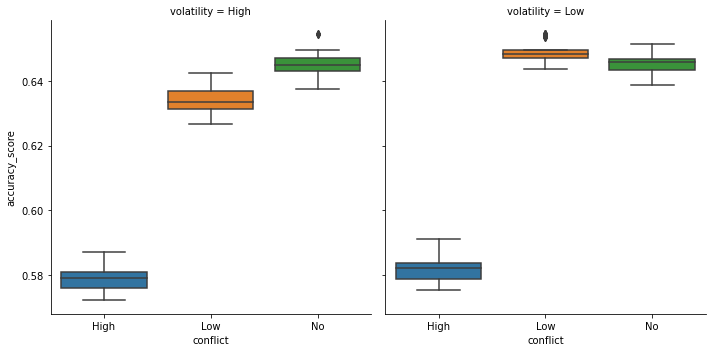

In [27]:
sns.catplot(x="conflict",y="accuracy_score",col="volatility",data=accuracy,kind='box')

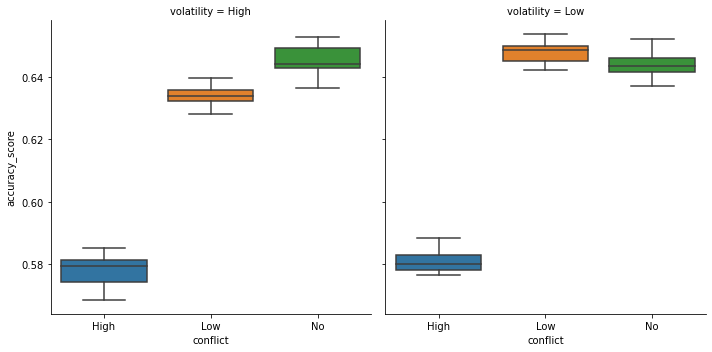

In [22]:
sns.catplot(x="conflict",y="accuracy_score",col="volatility",data=accuracy,kind='box')

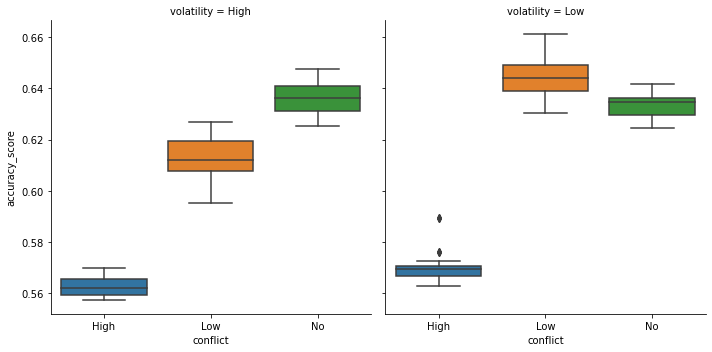

In [11]:
sns.catplot(x="conflict",y="accuracy_score",col="volatility",data=accuracy.loc[accuracy["condition"]=="iSPN-Control"],kind='box')

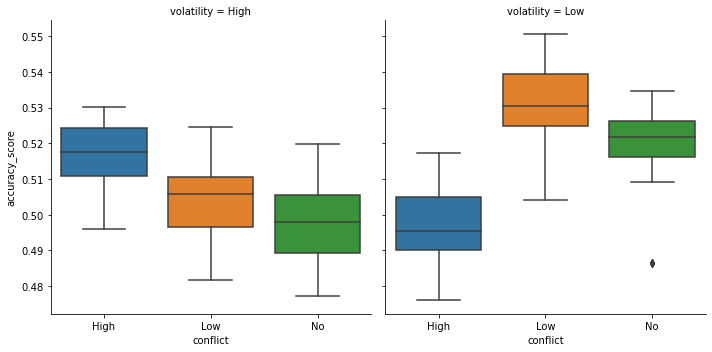

In [12]:
sns.catplot(x="conflict",y="accuracy_score",col="volatility",data=accuracy.loc[accuracy["condition"]=="iSPN-Stim"],kind='box')

In [28]:
g1 = sns.catplot(x="condition",y="coefficients(animal)",col="conflict + volatility",data=accuracy,kind='bar',col_wrap=3,hue="animal_id")
for ax in g1.axes:
    xlims = ax.get_xlim()
    ax.hlines(y=0,xmin=xlims[0],xmax=xlims[1],color='k',ls='dashed',lw=2.0)
    ax.set_xlim(xlims[0],xlims[1])
    

ValueError: Could not interpret input 'condition'